In [ ]:
#Copyright 2025 Stevens Ricardo Bohorquez Ruiz

#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

# IA Ensambles - Car Evaluation Dataset

En este notebook aplicaremos técnicas de ensambles sobre el conjunto de datos **Car Evaluation**, usando los métodos:

- **Bagging** (Random Forest)
- **Boosting** (AdaBoost y Gradient Boosting)
- **Stacking**

El objetivo es comparar su rendimiento y determinar cuál se ajusta mejor al problema de clasificación.


#**Introducción**

La clasificación es una técnica fundamental en el análisis de datos que permite categorizar elementos en grupos específicos. En este escenario, presentamos un conjunto de datos cuyo objetivo es evaluar la calidad de los carros basándose en diversas características como el precio de compra, el costo de mantenimiento, el número de puertas, la capacidad de pasajeros, el tamaño del maletero y el nivel de seguridad. Utilizando metodos de ensambles para este problema de clasificación, podemos predecir la evaluación del coche, que puede ser inaceptable, aceptable, bueno o muy bueno. Este enfoque es crucial para la industria automotriz, ya que permite identificar rápidamente los coches que cumplen con los estándares de calidad y seguridad, facilitando la toma de decisiones en la compra y venta de vehículos.

Para la industria automotriz,  es importante entender el comportamiento del consumidor especialmente cuales son aquellos factores determinantes en la elegibilidad de los carros. Por tal motivo, es esencial identificar de manera precisa las características que determinan la calidad de un vehículo, explorarando y aplicando diferentes metodos de ensambles bajo las categorias de bagging boosting Y stacking.

### **Problema**: Classification

### **Dataset**: https://archive.ics.uci.edu/dataset/19/car+evaluation

# Variables

**buying:** Precio de compra del coche. Los valores posibles son: vhigh (muy alto), high (alto), med (medio), low (bajo).

**maint:** Costo de mantenimiento del coche. Los valores posibles son: vhigh (muy alto), high (alto), med (medio), low (bajo).

**doors:** Número de puertas del coche. Los valores posibles son: 2, 3, 4, 5more (más de 5).

**persons:** Capacidad en términos de número de personas que puede llevar el coche. Los valores posibles son: 2, 4, more (más de 4).

**lug_boot:** Tamaño del maletero. Los valores posibles son: small (pequeño), med (medio), big (grande).

**safety:** Nivel de seguridad estimado del coche. Los valores posibles son: low (bajo), med (medio), high (alto).

**class:** (Target) Evaluación del coche. Los valores posibles son: unacc (inaceptable), acc (aceptable), good (bueno), vgood (muy bueno)

# **PLANTEAMIENTO DE LA SOLUCIÓN**

## Libraries

In [140]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ConfusionMatrix, ROCAUC
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

In [108]:
!pip install facets #Se utiliza facets para una visualizacion mas interactiva de la data

In [109]:
from IPython.core.display import display, HTML

In [110]:
!pip install ucimlrepo

In [111]:
from ucimlrepo import fetch_ucirepo

car_evaluation = fetch_ucirepo(id=19)

X = car_evaluation.data.features
y = car_evaluation.data.targets

print(car_evaluation)

{'data': {'ids': None, 'features':      buying  maint  doors persons lug_boot safety
0     vhigh  vhigh      2       2    small    low
1     vhigh  vhigh      2       2    small    med
2     vhigh  vhigh      2       2    small   high
3     vhigh  vhigh      2       2      med    low
4     vhigh  vhigh      2       2      med    med
...     ...    ...    ...     ...      ...    ...
1723    low    low  5more    more      med    med
1724    low    low  5more    more      med   high
1725    low    low  5more    more      big    low
1726    low    low  5more    more      big    med
1727    low    low  5more    more      big   high

[1728 rows x 6 columns], 'targets':       class
0     unacc
1     unacc
2     unacc
3     unacc
4     unacc
...     ...
1723   good
1724  vgood
1725  unacc
1726   good
1727  vgood

[1728 rows x 1 columns], 'original':      buying  maint  doors persons lug_boot safety  class
0     vhigh  vhigh      2       2    small    low  unacc
1     vhigh  vhigh      2       

# **EDA**

In [112]:
df = pd.DataFrame(X, columns=car_evaluation.metadata.features)
df['class'] = y
df.to_csv('car_evaluation.csv', index=False)

print("Datos exportados a 'car_evaluation.csv'")

Datos exportados a 'car_evaluation.csv'


In [113]:
df = pd.read_csv('car_evaluation.csv')
print(df)

     buying  maint  doors persons lug_boot safety  class
0     vhigh  vhigh      2       2    small    low  unacc
1     vhigh  vhigh      2       2    small    med  unacc
2     vhigh  vhigh      2       2    small   high  unacc
3     vhigh  vhigh      2       2      med    low  unacc
4     vhigh  vhigh      2       2      med    med  unacc
...     ...    ...    ...     ...      ...    ...    ...
1723    low    low  5more    more      med    med   good
1724    low    low  5more    more      med   high  vgood
1725    low    low  5more    more      big    low  unacc
1726    low    low  5more    more      big    med   good
1727    low    low  5more    more      big   high  vgood

[1728 rows x 7 columns]


In [114]:
print(df.shape)
print("The number of rows is: ", df.shape[0])
print("The number of features is: ", df.shape[1])

(1728, 7)
The number of rows is:  1728
The number of features is:  7


In [115]:
df.describe()


,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


In [116]:
cat_cols = [c for c in df.columns if is_string_dtype(df[c])]
print("Columnas categóricas:", cat_cols)

Columnas categóricas: ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']


In [117]:
print(df.dtypes)


buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object


In [118]:
print(df.isnull().sum())

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [120]:
print(df.nunique())

buying      4
maint       4
doors       4
persons     3
lug_boot    3
safety      3
class       4
dtype: int64


In [122]:
print("Registros Duplicados:", df[df.duplicated()].shape[0])

Registros Duplicados: 0


### **Convertimos data categorica en numeros**

In [123]:
label_encoders = {}
for column in df.columns[:-1]:  # menos la variable objetivo 'class'
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column]).astype('int64')

target_encoder = LabelEncoder()
df['class'] = target_encoder.fit_transform(df['class']).astype('int64')

X = df.drop('class', axis=1).astype('int64')
y = df['class'].astype('int64')

In [124]:
print(df)
print(df.dtypes)

      buying  maint  doors  persons  lug_boot  safety  class
0          3      3      0        0         2       1      2
1          3      3      0        0         2       2      2
2          3      3      0        0         2       0      2
3          3      3      0        0         1       1      2
4          3      3      0        0         1       2      2
...      ...    ...    ...      ...       ...     ...    ...
1723       1      1      3        2         1       2      1
1724       1      1      3        2         1       0      3
1725       1      1      3        2         0       1      2
1726       1      1      3        2         0       2      1
1727       1      1      3        2         0       0      3

[1728 rows x 7 columns]
buying      int64
maint       int64
doors       int64
persons     int64
lug_boot    int64
safety      int64
class       int64
dtype: object


In [125]:
print(X)
print(X.dtypes)

      buying  maint  doors  persons  lug_boot  safety
0          3      3      0        0         2       1
1          3      3      0        0         2       2
2          3      3      0        0         2       0
3          3      3      0        0         1       1
4          3      3      0        0         1       2
...      ...    ...    ...      ...       ...     ...
1723       1      1      3        2         1       2
1724       1      1      3        2         1       0
1725       1      1      3        2         0       1
1726       1      1      3        2         0       2
1727       1      1      3        2         0       0

[1728 rows x 6 columns]
buying      int64
maint       int64
doors       int64
persons     int64
lug_boot    int64
safety      int64
dtype: object


In [126]:
print(y)
print(y.dtypes)

0       2
1       2
2       2
3       2
4       2
       ..
1723    1
1724    3
1725    2
1726    1
1727    3
Name: class, Length: 1728, dtype: int64
int64


In [127]:
num_cols = [c for c in df.columns if is_numeric_dtype(df[c])]
print("Columnas numéricas:", num_cols)

Columnas numéricas: ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']


### **Analisis Univariable**

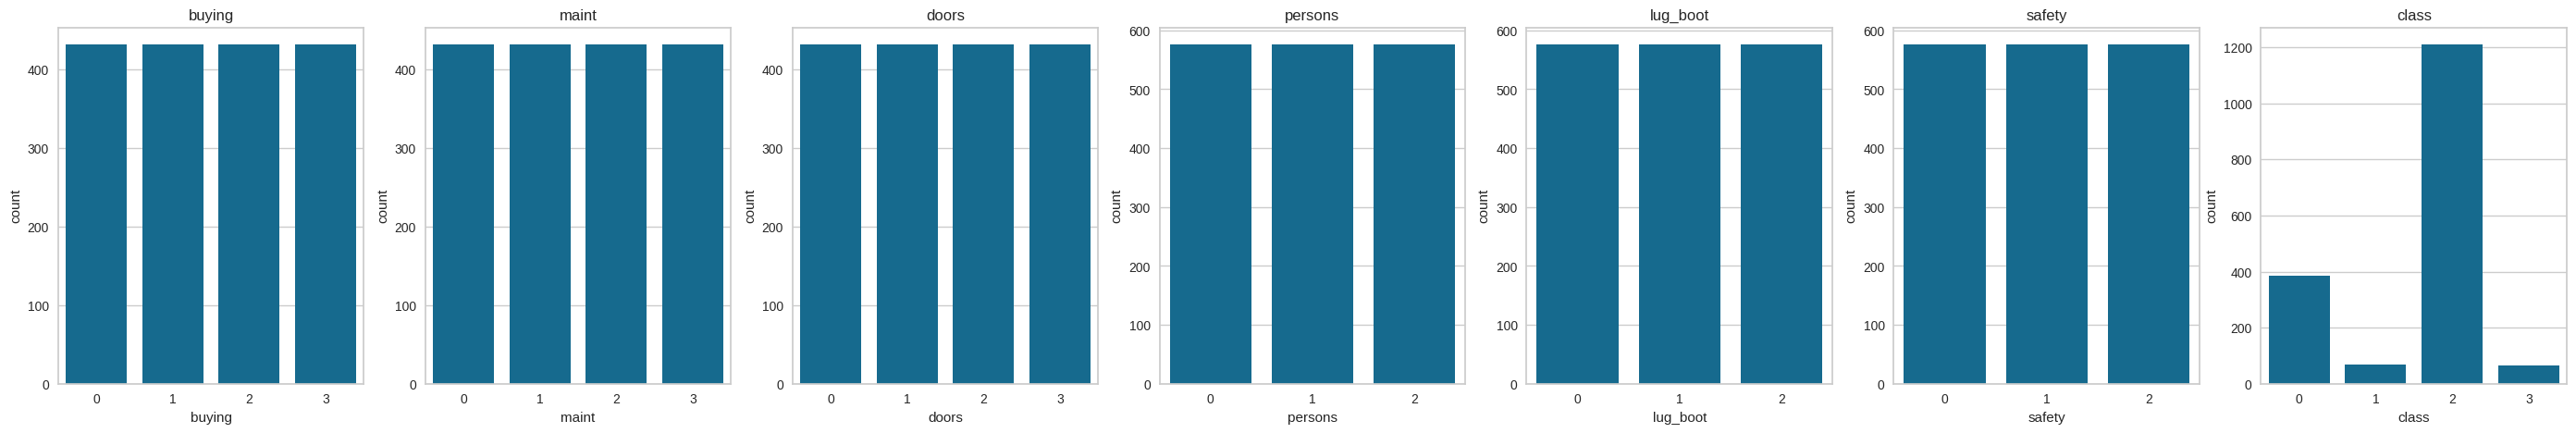

In [128]:
if cat_cols:
    fig, ax = plt.subplots(1, len(cat_cols), figsize=(5 * len(cat_cols), 5))
    if len(cat_cols) == 1: ax = [ax]
    for i, c in enumerate(cat_cols):
        sns.countplot(x=df[c], ax=ax[i]); ax[i].set_title("" + c)
    plt.show()

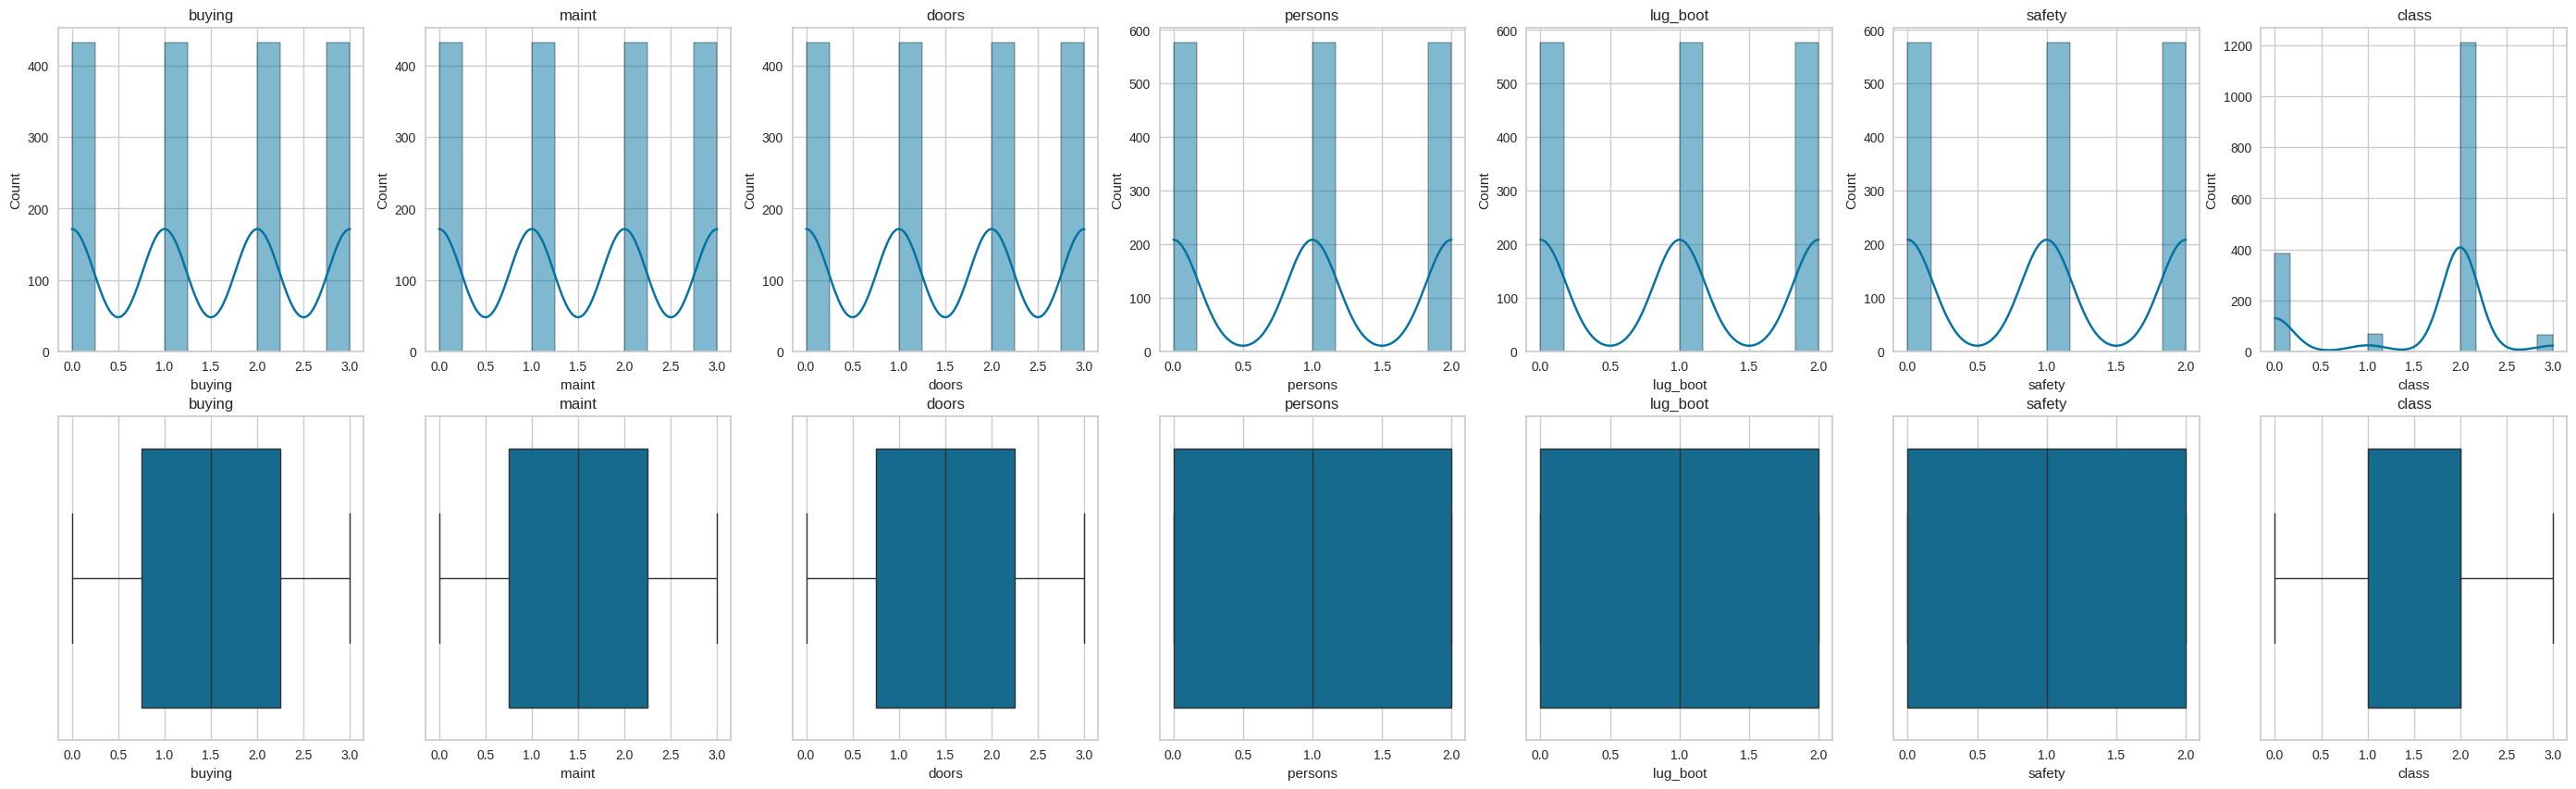

In [129]:
if num_cols:
    fig, ax = plt.subplots(2, len(num_cols), figsize=(5 * len(num_cols), 10))
    for i, c in enumerate(num_cols):
        sns.histplot(df[c], kde=True, ax=ax[0, i]); ax[0, i].set_title(c)
        sns.boxplot(x=df[c], ax=ax[1, i]); ax[1, i].set_title(c)
    plt.show()

### **Analsis Multivariado**

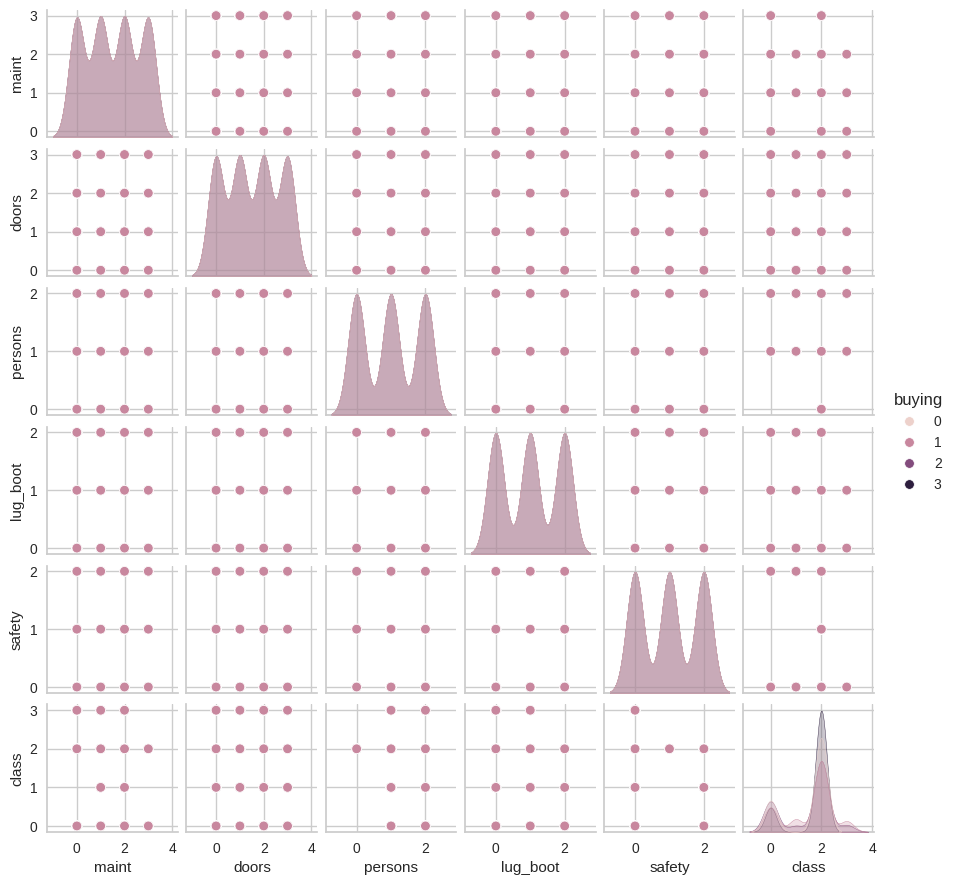

In [130]:
hue_param = 'buying'  #@param ["buying", "maint", "doors", "persons", "lug_boot", "safety"]

sns.pairplot(df, hue=hue_param, height=1.5)
plt.show()

array([[<Axes: title={'center': 'buying'}>,
        <Axes: title={'center': 'maint'}>,
        <Axes: title={'center': 'doors'}>],
       [<Axes: title={'center': 'persons'}>,
        <Axes: title={'center': 'lug_boot'}>,
        <Axes: title={'center': 'safety'}>],
       [<Axes: title={'center': 'class'}>, <Axes: >, <Axes: >]],
      dtype=object)

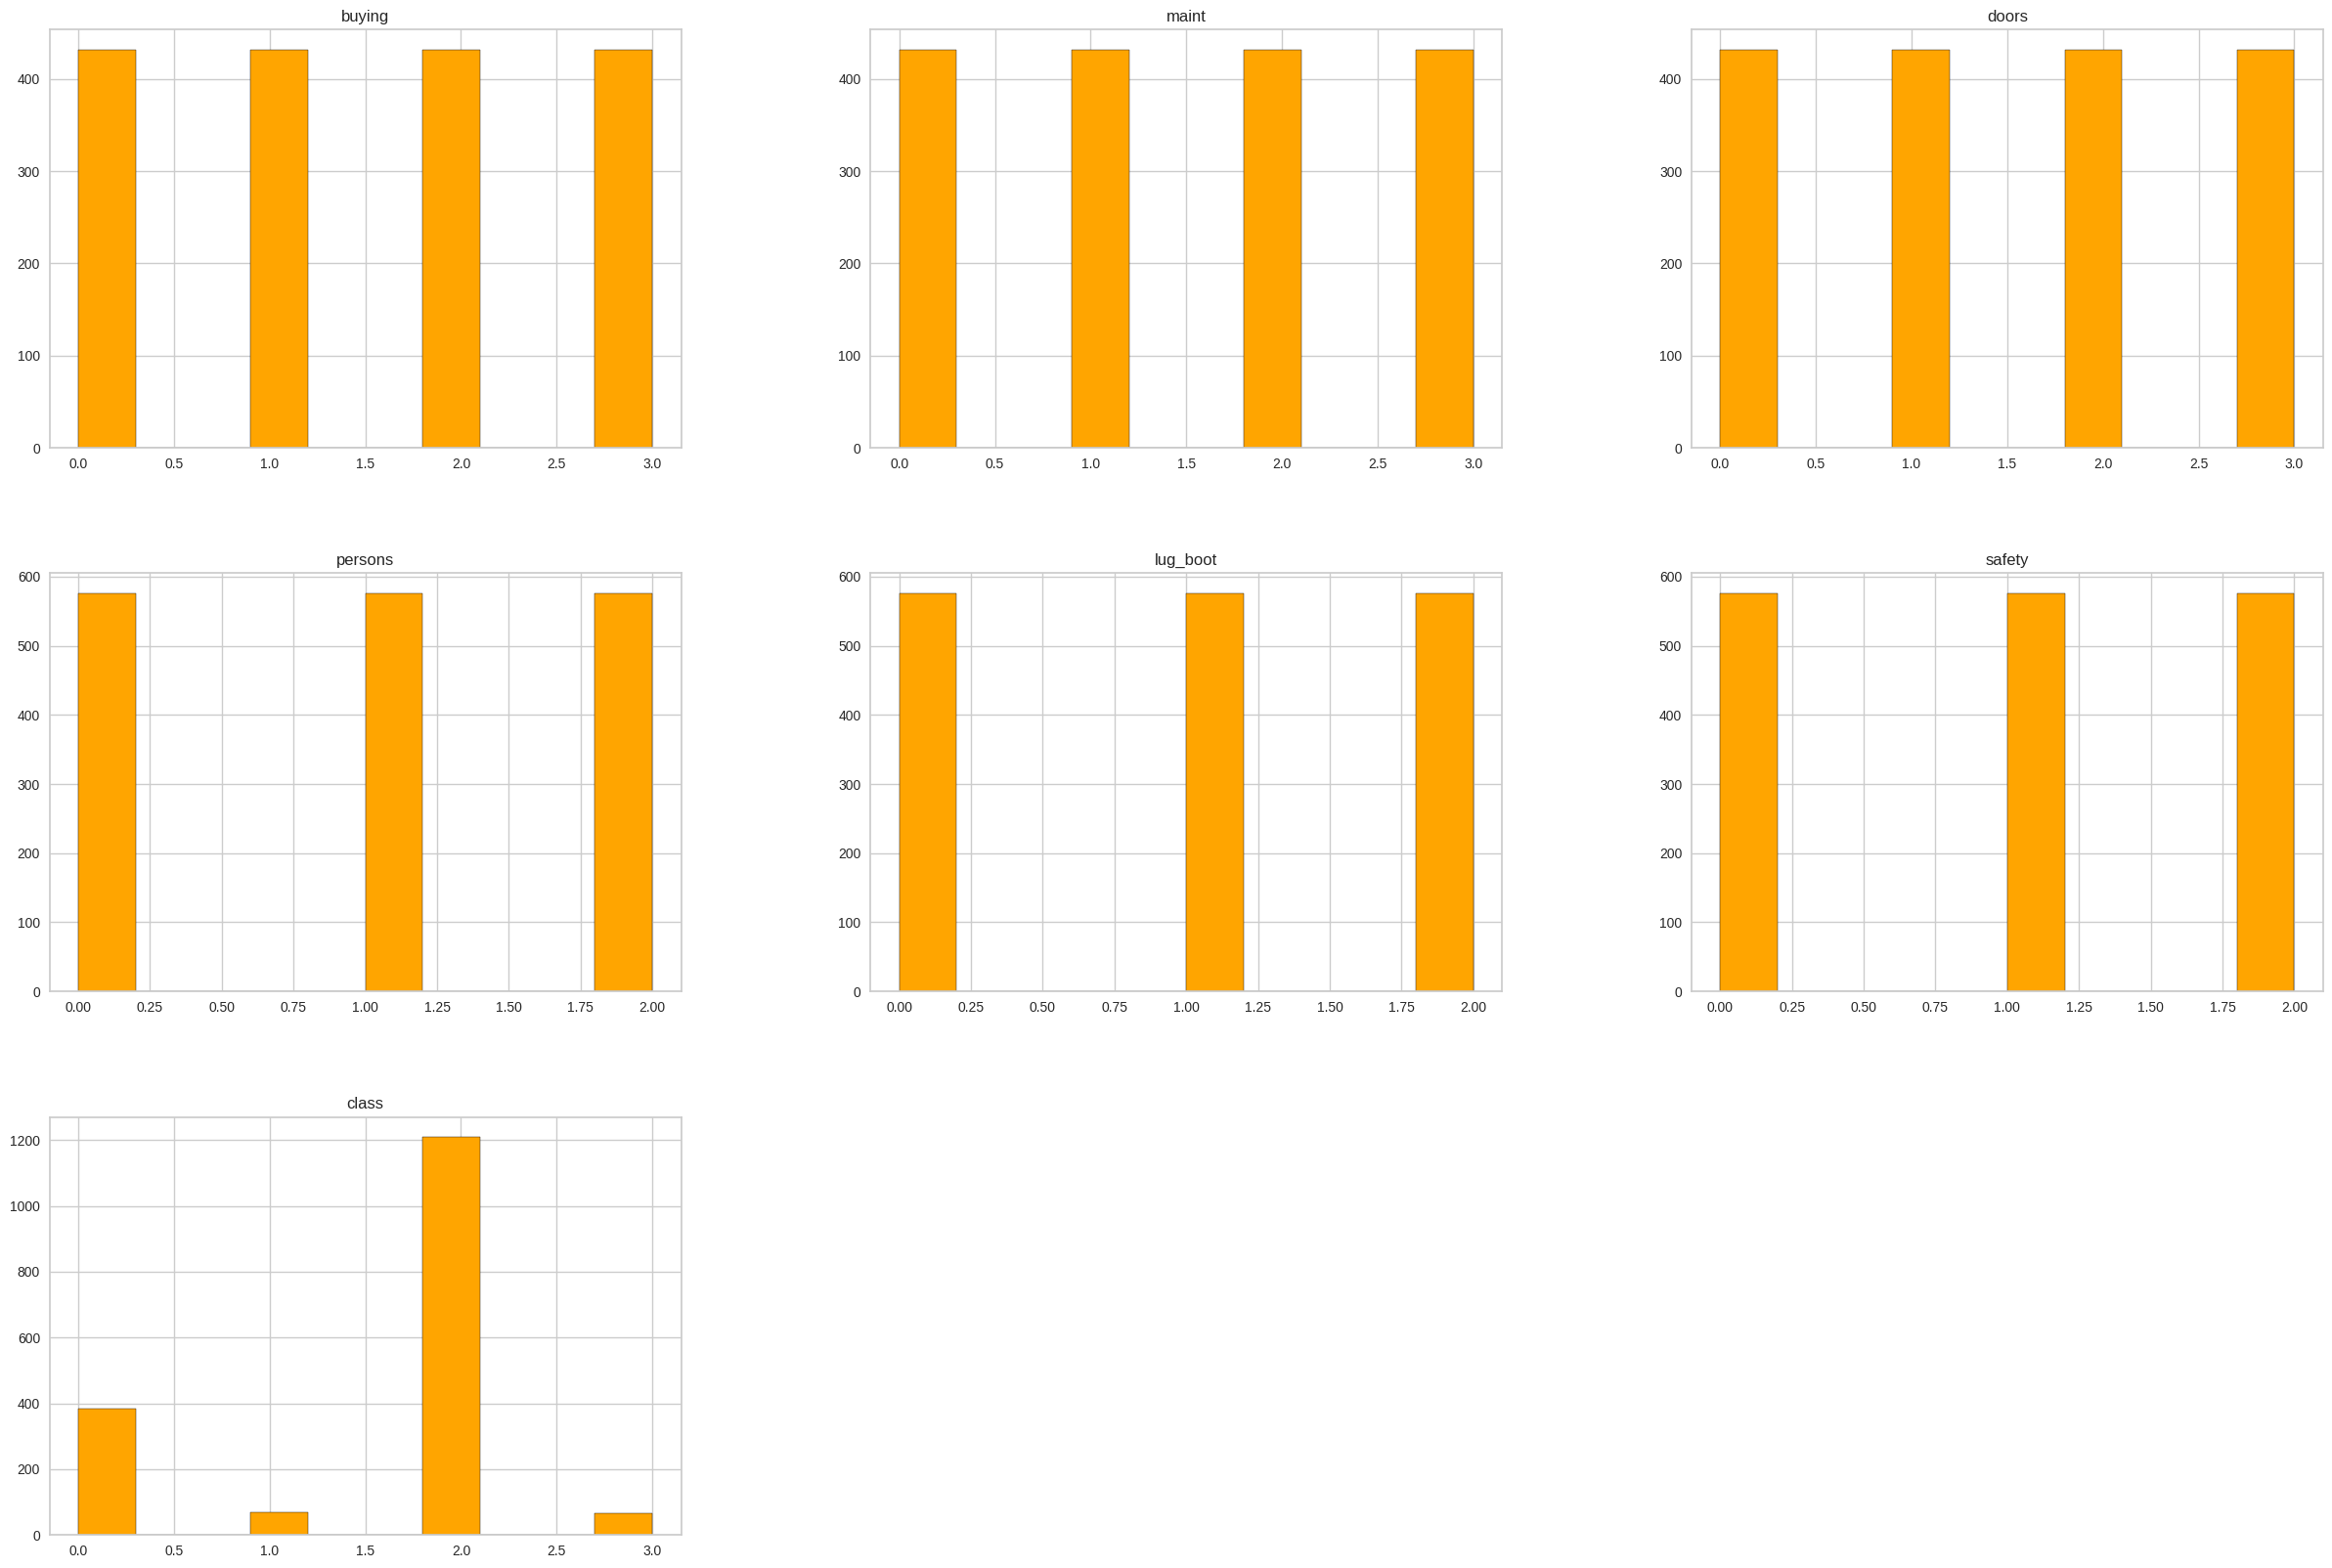

In [131]:
df.hist(figsize=(30,20),bins=10,edgecolor='black',color='orange')

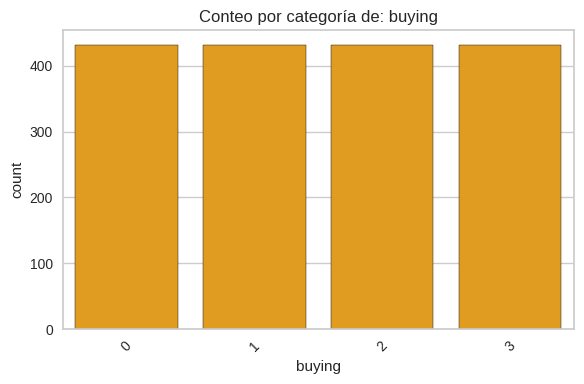

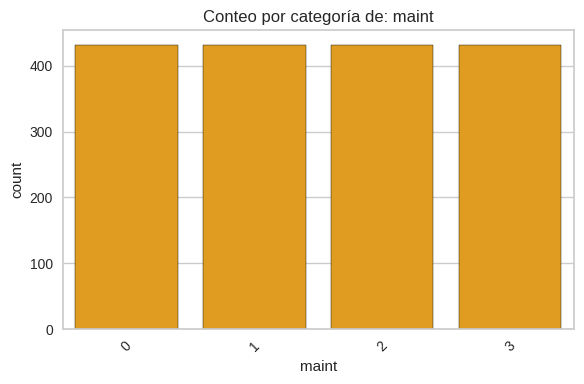

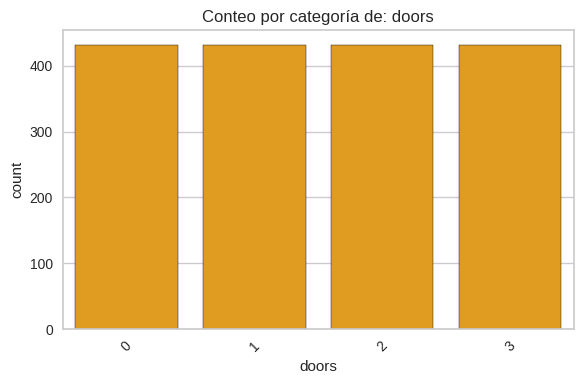

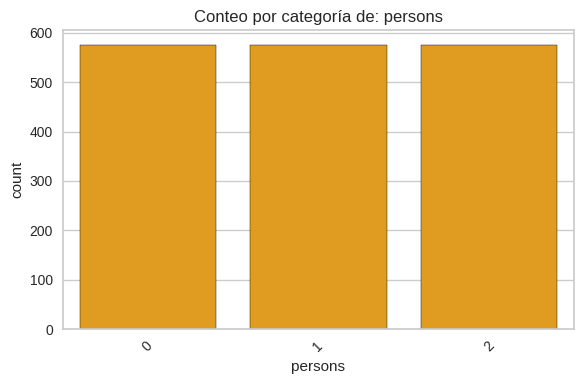

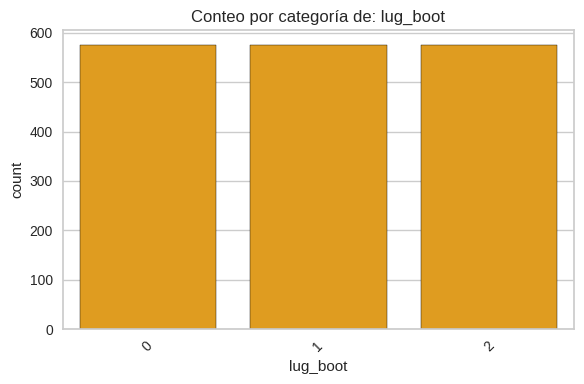

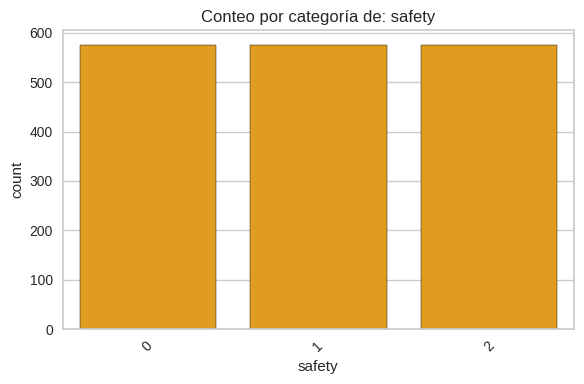

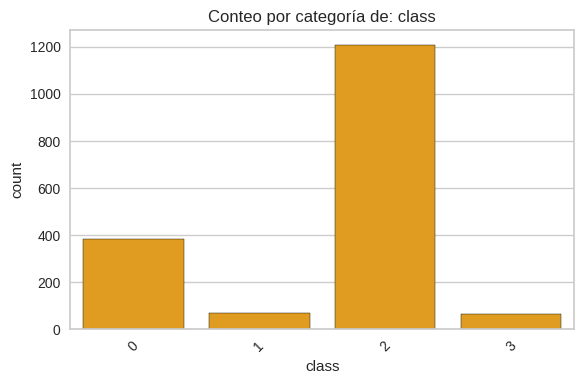

In [132]:
for col in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, color='orange', edgecolor='black')
    plt.title(f"Conteo por categoría de: {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Identificando posibles outliers

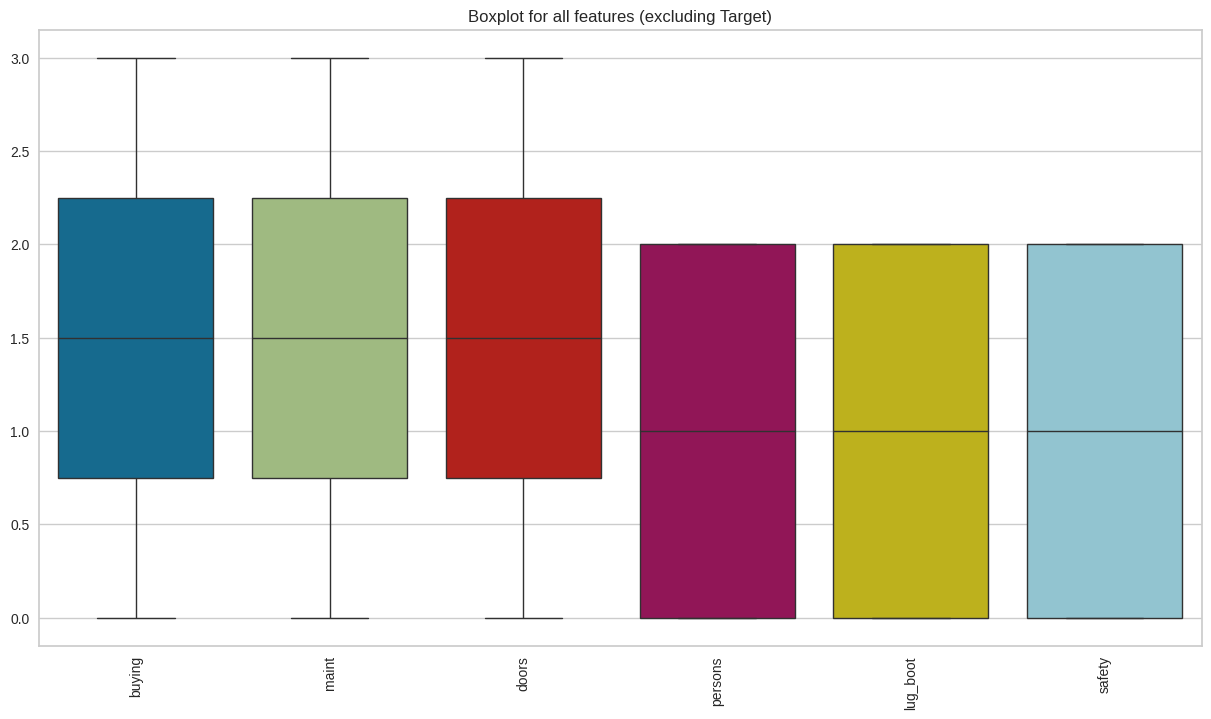

In [133]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df.drop(columns='class'))
plt.xticks(rotation=90)
plt.title("Boxplot for all features (excluding Target)")
plt.show()

### Se utiliza facets para tener una mejor visualizacion de la data

In [134]:
SAMPLE_SIZE = 500 #@param

df_dive = df.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=df_dive)
display(HTML(html))

### Matriz de correlación con valores númericos

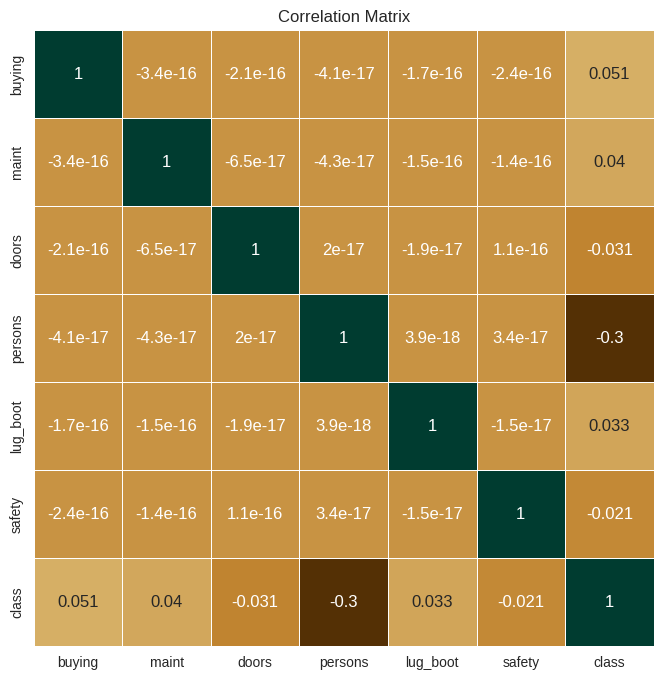

                buying         maint         doors       persons  \
buying    1.000000e+00 -3.436808e-16 -2.097088e-16 -4.089152e-17   
maint    -3.436808e-16  1.000000e+00 -6.466021e-17 -4.272143e-17   
doors    -2.097088e-16 -6.466021e-17  1.000000e+00  1.956599e-17   
persons  -4.089152e-17 -4.272143e-17  1.956599e-17  1.000000e+00   
lug_boot -1.691262e-16 -1.549092e-16 -1.942523e-17  3.854941e-18   
safety   -2.439415e-16 -1.404810e-16  1.062757e-16  3.392348e-17   
class     5.142422e-02  4.019365e-02 -3.132740e-02 -2.994683e-01   

              lug_boot        safety     class  
buying   -1.691262e-16 -2.439415e-16  0.051424  
maint    -1.549092e-16 -1.404810e-16  0.040194  
doors    -1.942523e-17  1.062757e-16 -0.031327  
persons   3.854941e-18  3.392348e-17 -0.299468  
lug_boot  1.000000e+00 -1.541976e-17  0.033184  
safety   -1.541976e-17  1.000000e+00 -0.021044  
class     3.318432e-02 -2.104372e-02  1.000000  

class       1.000000
buying      0.051424
maint       0.040194

In [135]:
corr_matrix = df.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='BrBG', cbar=False, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()
print(corr_matrix)

mapcorr = df.corr()
correlation_with_target = mapcorr["class"].sort_values(ascending=False)
print()
print(correlation_with_target)

### DIVISION: Conjuntos Train y Test

In [136]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # y es tu vector de clases tipo 'unacc', 'acc', etc.

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

## Bagging - Random Forest Classifier

Accuracy: 0.9739884393063584
              precision    recall  f1-score   support

           0       0.99      0.90      0.94        83
           1       0.65      1.00      0.79        11
           2       0.99      1.00      1.00       235
           3       1.00      0.94      0.97        17

    accuracy                           0.97       346
   macro avg       0.91      0.96      0.92       346
weighted avg       0.98      0.97      0.98       346



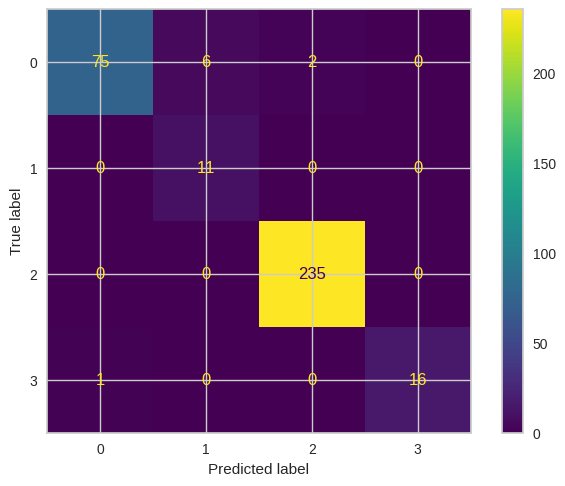

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelo Bagging - Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
ConfusionMatrixDisplay.from_predictions(y_test, rf_preds)


## Boosting - AdaBoost y Gradient Boosting

AdaBoost Accuracy: 0.8352601156069365
              precision    recall  f1-score   support

           0       0.64      0.73      0.68        83
           1       0.00      0.00      0.00        11
           2       0.91      0.96      0.94       235
           3       1.00      0.12      0.21        17

    accuracy                           0.84       346
   macro avg       0.64      0.45      0.46       346
weighted avg       0.82      0.84      0.81       346



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Gradient Boosting Accuracy: 0.9653179190751445
              precision    recall  f1-score   support

           0       0.99      0.89      0.94        83
           1       0.55      1.00      0.71        11
           2       0.99      1.00      1.00       235
           3       1.00      0.82      0.90        17

    accuracy                           0.97       346
   macro avg       0.88      0.93      0.89       346
weighted avg       0.98      0.97      0.97       346



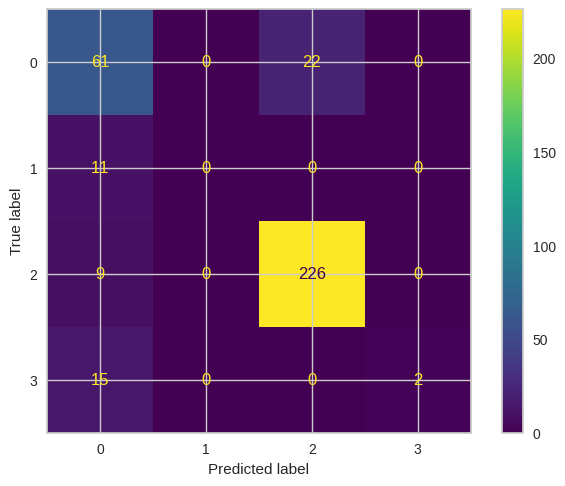

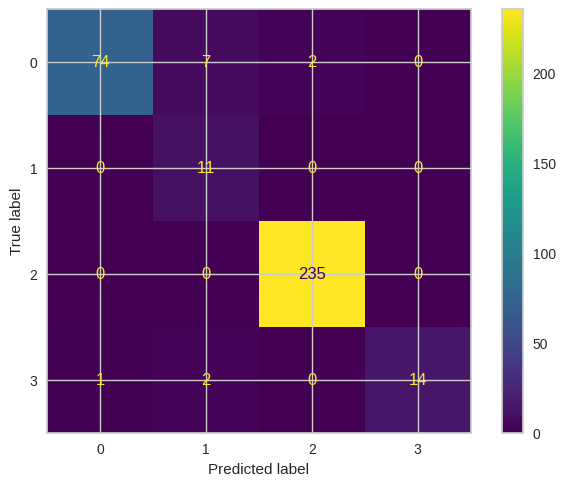

In [138]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
ada_preds = ada.predict(X_test)

print("AdaBoost Accuracy:", accuracy_score(y_test, ada_preds))
print(classification_report(y_test, ada_preds))
ConfusionMatrixDisplay.from_predictions(y_test, ada_preds)

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_preds))
print(classification_report(y_test, gb_preds))
ConfusionMatrixDisplay.from_predictions(y_test, gb_preds)


## Stacking Classifier

Stacking Accuracy: 0.9710982658959537
              precision    recall  f1-score   support

           0       0.99      0.89      0.94        83
           1       0.61      1.00      0.76        11
           2       0.99      1.00      1.00       235
           3       1.00      0.94      0.97        17

    accuracy                           0.97       346
   macro avg       0.90      0.96      0.92       346
weighted avg       0.98      0.97      0.97       346



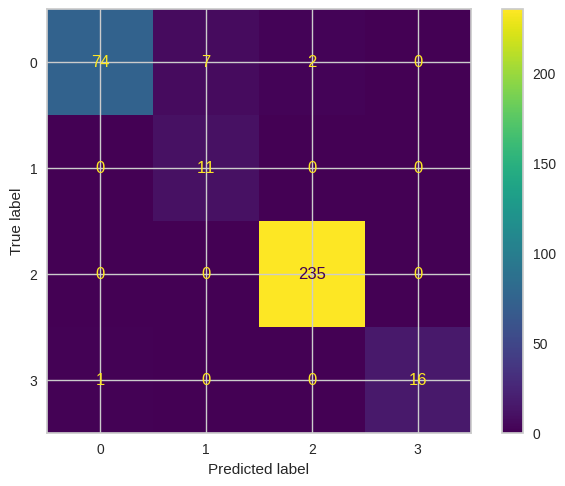

In [139]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Modelos base
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]

# Meta-modelo
meta_learner = LogisticRegression()

stack_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
stack_model.fit(X_train, y_train)
stack_preds = stack_model.predict(X_test)

print("Stacking Accuracy:", accuracy_score(y_test, stack_preds))
print(classification_report(y_test, stack_preds))
ConfusionMatrixDisplay.from_predictions(y_test, stack_preds)


#Visualización ROC AUC

Curva ROC multiclase comparativa entre todos los modelos

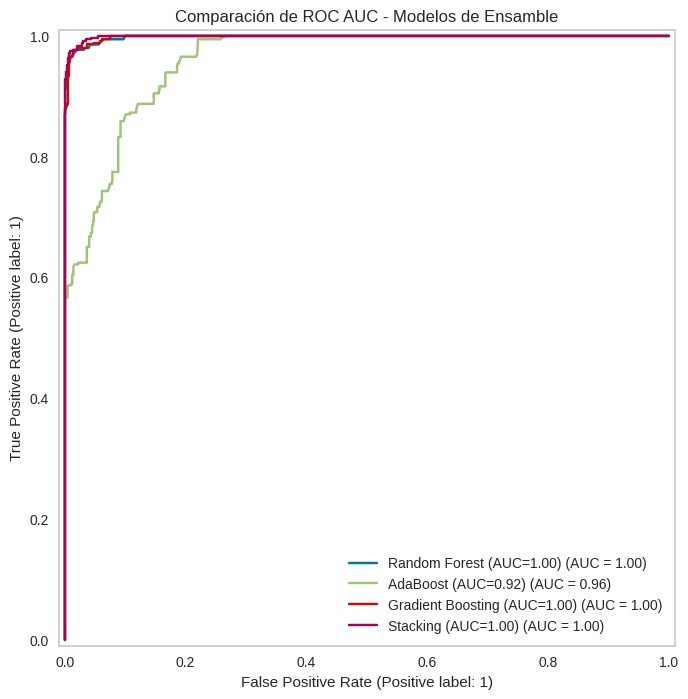

In [141]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Binarizar las etiquetas (One-vs-Rest) para ROC AUC multiclase
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

model_dict = {
    "Random Forest": rf_model,
    "AdaBoost": ada,
    "Gradient Boosting": gb,
    "Stacking": stack_model
}

# Mostrar curva ROC por modelo
plt.figure(figsize=(12, 8))

for name, model in model_dict.items():
    y_score = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
    RocCurveDisplay.from_predictions(
        y_test_bin.ravel(), y_score.ravel(), name=f"{name} (AUC={roc_auc:.2f})", ax=plt.gca()
    )

plt.title("Comparación de ROC AUC - Modelos de Ensamble")
plt.grid()
plt.show()


#Tabla resumen de métricas

Tabla ordenada por F1-Score para facilitar la elección del mejor modelo

In [142]:
from sklearn.metrics import precision_score, recall_score, f1_score

def obtener_metricas(modelo, X_test, y_test, nombre):
    pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, average='weighted')
    rec = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')
    return [nombre, acc, prec, rec, f1]

resultados = []

resultados.append(obtener_metricas(rf_model, X_test, y_test, "Random Forest"))
resultados.append(obtener_metricas(ada, X_test, y_test, "AdaBoost"))
resultados.append(obtener_metricas(gb, X_test, y_test, "Gradient Boosting"))
resultados.append(obtener_metricas(stack_model, X_test, y_test, "Stacking"))

tabla_metricas = pd.DataFrame(resultados, columns=["Modelo", "Accuracy", "Precision", "Recall", "F1-Score"])
tabla_metricas = tabla_metricas.sort_values(by="F1-Score", ascending=False)
print(tabla_metricas)


              Modelo  Accuracy  Precision    Recall  F1-Score
0      Random Forest  0.973988   0.979891  0.973988  0.975242
3           Stacking  0.971098   0.978706  0.971098  0.972777
2  Gradient Boosting  0.965318   0.976764  0.965318  0.967955
1           AdaBoost  0.835260   0.820499  0.835260  0.809439


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
